### import the dependencies

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

from torchdiffeq import odeint

from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

DATA_PATH = os.path.join("..", "Dataset", "raw_RRI_segments.csv")
OUT_MODEL = os.path.join("..", "Three_Class_Models", "saved_models", "raw_hybrid_best.pth")

### Load PSR dataset and preprocess

In [2]:
df = pd.read_csv(DATA_PATH)

# pick raw RRI columns (prefix 'r_')
feature_cols = [c for c in df.columns if c.startswith("r_")]
meta_cols = ["patient_id", "record_id", "label", "label_str", "orig_len"]

assert len(feature_cols) > 0, "No r_ columns found in CSV"

# Extract features
X = df[feature_cols].values.astype(np.float32)

# Keep labels as float first (avoid invalid int cast)
y_raw = df["label"].values

# Drop rows where features or labels are invalid
mask_good = np.isfinite(X).all(axis=1) & np.isfinite(y_raw) & (y_raw >= 0)

# Apply mask
X = X[mask_good]
y = y_raw[mask_good].astype(int)

# Print stats
print("Unique labels:", np.unique(y))
print("Loaded raw samples:", X.shape, "class counts:", np.bincount(y))


Unique labels: [0 1 2]
Loaded raw samples: (14357, 50) class counts: [4800 4757 4800]


### Train / val / test split, scaling and SMOTE (apply SMOTE only to training set)

In [3]:
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_SEED
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.2, stratify=y_temp, random_state=RANDOM_SEED
)

print("Splits -> train:", X_train.shape, "val:", X_val.shape, "test:", X_test.shape)

# Standardize using training stats
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

X_train_res, y_train_res = X_train, y_train


Splits -> train: (9188, 50) val: (2297, 50) test: (2872, 50)


### Define model class

In [4]:
# --- Model definitions (Hybrid NODE + Attention) ---
class ODEFunc(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, 64),
            nn.Tanh(),
            nn.Linear(64, dim)
        )
    def forward(self, t, x):
        return self.net(x)

class SelfAttention(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.query = nn.Linear(dim, dim)
        self.key = nn.Linear(dim, dim)
        self.value = nn.Linear(dim, dim)
        self.scale = dim ** 0.5
    def forward(self, x):
        # x: [batch, dim] -> [batch, 1, dim]
        x1 = x.unsqueeze(1)
        Q = self.query(x1)
        K = self.key(x1)
        V = self.value(x1)
        scores = torch.softmax(torch.bmm(Q, K.transpose(1,2)) / self.scale, dim=-1)
        out = torch.bmm(scores, V)  # [batch,1,dim]
        return out.squeeze(1)

class HybridNODEAttentionModel(nn.Module):
    def __init__(self, dim, num_classes):
        super().__init__()
        self.odefunc = ODEFunc(dim)
        self.attn = SelfAttention(dim)
        self.classifier = nn.Sequential(
            nn.Linear(dim, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )
    def forward(self, x):
        # x: [batch, dim]
        t = torch.tensor([0.0, 1.0], dtype=x.dtype, device=x.device)
        ode_out = odeint(self.odefunc, x, t)[-1]
        attn_out = self.attn(ode_out)
        return self.classifier(attn_out)


### Prepare DataLoaders

In [5]:
BATCH_SIZE = 32
train_ds = TensorDataset(torch.from_numpy(X_train_res.astype(np.float32)), torch.from_numpy(y_train_res.astype(np.int64)))
val_ds = TensorDataset(torch.from_numpy(X_val.astype(np.float32)), torch.from_numpy(y_val.astype(np.int64)))
test_ds = TensorDataset(torch.from_numpy(X_test.astype(np.float32)), torch.from_numpy(y_test.astype(np.int64)))

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_dim = X_train_res.shape[1]
num_classes = int(np.unique(y).size)

### Train model (hyperparameter tuning)

In [6]:
from sklearn.model_selection import KFold
from torch.utils.data import Subset
import torch.nn.functional as F
from sklearn.metrics import f1_score
import itertools
import numpy as np
import torch

def train_with_kfold_tuning(model_class, input_dim, num_classes,
                            full_dataset,
                            param_grid,
                            save_path,
                            epochs=8, patience=2,
                            k_folds=5, device='cuda'):
    best_global_f1 = 0.0
    best_params = None
    best_state = None

    kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    combos = list(itertools.product(*param_grid.values()))
    print(f"Total combinations: {len(combos)}  |  Using {k_folds}-fold cross-validation")

    for combo in combos:
        params = dict(zip(param_grid.keys(), combo))
        print(f"\nTesting hyperparameters: {params}")
        fold_f1s = []

        for fold, (train_idx, val_idx) in enumerate(kfold.split(np.arange(len(full_dataset)))):
            train_subset = Subset(full_dataset, train_idx)
            val_subset = Subset(full_dataset, val_idx)

            train_loader = DataLoader(train_subset, batch_size=params["batch_size"], shuffle=True)
            val_loader = DataLoader(val_subset, batch_size=params["batch_size"], shuffle=False)

            model = model_class(dim=input_dim, num_classes=num_classes).to(device)
            optimizer = (
                torch.optim.Adam(model.parameters(), lr=params["lr"])
                if params["optimizer"] == "adam"
                else torch.optim.SGD(model.parameters(), lr=params["lr"], momentum=0.9)
            )
            criterion = nn.CrossEntropyLoss()

            local_best = 0.0
            no_improve = 0

            for epoch in range(epochs):
                model.train()
                total_loss = 0
                for xb, yb in train_loader:
                    xb, yb = xb.to(device), yb.to(device)
                    optimizer.zero_grad()
                    out = model(xb)
                    loss = criterion(out, yb)
                    loss.backward()
                    optimizer.step()
                    total_loss += loss.item() * xb.size(0)

                # Validation
                model.eval()
                preds, trues = [], []
                with torch.no_grad():
                    for xb, yb in val_loader:
                        xb, yb = xb.to(device), yb.to(device)
                        out = model(xb)
                        preds.extend(torch.argmax(out, dim=1).cpu().numpy())
                        trues.extend(yb.cpu().numpy())

                val_f1 = f1_score(trues, preds, average="weighted")
                if val_f1 > local_best:
                    local_best = val_f1
                    no_improve = 0
                else:
                    no_improve += 1
                    if no_improve >= patience:
                        break

            fold_f1s.append(local_best)
            print(f"  Fold {fold+1}/{k_folds} F1: {local_best:.4f}")

        mean_f1 = np.mean(fold_f1s)
        print(f"Mean F1 for params {params}: {mean_f1:.4f}")

        if mean_f1 > best_global_f1:
            best_global_f1 = mean_f1
            best_params = params
            best_state = model.state_dict().copy()
            torch.save(best_state, save_path)
            print("  ✅ New best model saved.")

    print(f"\nBest overall F1: {best_global_f1:.4f} with params {best_params}")
    return best_params, best_global_f1, best_state



In [7]:
train_dataset = TensorDataset(torch.from_numpy(X_train_res.astype(np.float32)), torch.from_numpy(y_train_res.astype(np.int64)))
val_dataset = TensorDataset(torch.from_numpy(X_val.astype(np.float32)), torch.from_numpy(y_val.astype(np.int64)))
test_dataset = TensorDataset(torch.from_numpy(X_test.astype(np.float32)), torch.from_numpy(y_test.astype(np.int64)))

input_dim = X_train_res.shape[1]
num_classes = int(np.unique(y).size)

In [8]:
full_dataset = TensorDataset(
    torch.from_numpy(X_train_res.astype(np.float32)),
    torch.from_numpy(y_train_res.astype(np.int64))
)

param_grid = {
    "lr": [1e-3, 5e-4],
    "batch_size": [16, 32],
    "optimizer": ["adam", "sgd"]
}

best_params, best_f1, best_state = train_with_kfold_tuning(
    HybridNODEAttentionModel, input_dim, num_classes,
    full_dataset, 
    param_grid, save_path=OUT_MODEL,
    epochs=8, patience=2, k_folds=5, device=device
)


Total combinations: 8  |  Using 5-fold cross-validation

Testing hyperparameters: {'lr': 0.001, 'batch_size': 16, 'optimizer': 'adam'}
  Fold 1/5 F1: 0.6258
  Fold 2/5 F1: 0.6255
  Fold 3/5 F1: 0.6320
  Fold 4/5 F1: 0.6316
  Fold 5/5 F1: 0.5809
Mean F1 for params {'lr': 0.001, 'batch_size': 16, 'optimizer': 'adam'}: 0.6192
  ✅ New best model saved.

Testing hyperparameters: {'lr': 0.001, 'batch_size': 16, 'optimizer': 'sgd'}
  Fold 1/5 F1: 0.5979
  Fold 2/5 F1: 0.5886
  Fold 3/5 F1: 0.6206
  Fold 4/5 F1: 0.5879
  Fold 5/5 F1: 0.5905
Mean F1 for params {'lr': 0.001, 'batch_size': 16, 'optimizer': 'sgd'}: 0.5971

Testing hyperparameters: {'lr': 0.001, 'batch_size': 32, 'optimizer': 'adam'}
  Fold 1/5 F1: 0.6222
  Fold 2/5 F1: 0.6293
  Fold 3/5 F1: 0.6301
  Fold 4/5 F1: 0.5896
  Fold 5/5 F1: 0.5930
Mean F1 for params {'lr': 0.001, 'batch_size': 32, 'optimizer': 'adam'}: 0.6128

Testing hyperparameters: {'lr': 0.001, 'batch_size': 32, 'optimizer': 'sgd'}
  Fold 1/5 F1: 0.5930
  Fold 2/5 F1

### Final evaluation on test set

In [9]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
import numpy as np
import torch

# --- Load best model for final evaluation ---
if best_state is not None:
    best_model = HybridNODEAttentionModel(dim=input_dim, num_classes=num_classes)
    best_model.load_state_dict(best_state)
    best_model = best_model.to(device)
    print("✅ Loaded best model from training.")
else:
    best_model = HybridNODEAttentionModel(dim=input_dim, num_classes=num_classes).to(device)
    print("⚠️ No best_state found, using new untrained model.")

# --- Create test loader if missing ---
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# --- Evaluate on test set ---
best_model.eval()
test_preds, test_trues = [], []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        outputs = best_model(xb)
        preds = torch.argmax(outputs, dim=1)
        test_preds.extend(preds.cpu().numpy())
        test_trues.extend(yb.cpu().numpy())

test_preds = np.array(test_preds)
test_trues = np.array(test_trues)

# --- Metrics ---
acc = accuracy_score(test_trues, test_preds)
f1 = f1_score(test_trues, test_preds, average="weighted")
precision = precision_score(test_trues, test_preds, average="weighted", zero_division=0)
recall = recall_score(test_trues, test_preds, average="weighted", zero_division=0)
cm = confusion_matrix(test_trues, test_preds)

print("\n📊 Final Test Results:")
print(f"Accuracy:  {acc:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")

print("\nDetailed classification report:")
print(classification_report(test_trues, test_preds, digits=4))

print("\nConfusion Matrix:")
print(cm)


✅ Loaded best model from training.

📊 Final Test Results:
Accuracy:  0.6027
F1 Score:  0.5976
Precision: 0.5942
Recall:    0.6027

Detailed classification report:
              precision    recall  f1-score   support

           0     0.5103    0.4896    0.4997       960
           1     0.5089    0.4779    0.4930       952
           2     0.7625    0.8396    0.7992       960

    accuracy                         0.6027      2872
   macro avg     0.5939    0.6024    0.5973      2872
weighted avg     0.5942    0.6027    0.5976      2872


Confusion Matrix:
[[470 358 132]
 [378 455 119]
 [ 73  81 806]]


In [10]:
input_dim = X_train_res.shape[1]
num_classes = int(np.unique(y).size)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = HybridNODEAttentionModel(dim=input_dim, num_classes=num_classes).to(DEVICE)
state_dict = torch.load(OUT_MODEL, map_location=DEVICE)
model.load_state_dict(state_dict)
model.eval()
print("✅ Loaded trained NODE model from", OUT_MODEL)

✅ Loaded trained NODE model from ../Three_Class_Models/saved_models/raw_hybrid_best.pth


In [11]:
import torch
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    classification_report, confusion_matrix
)
import numpy as np

# --- Load model from saved .pth ---
model_path = os.path.join("..", "Three_Class_Models", "saved_models", "raw_hybrid_best.pth")

# ✅ use the exact same model class you trained
best_model = HybridNODEAttentionModel(dim=input_dim, num_classes=num_classes).to(device)

# ✅ load trained weights
state_dict = torch.load(model_path, map_location=device)
best_model.load_state_dict(state_dict)
best_model.eval()
print(f"✅ Loaded trained model from: {model_path}")

# --- Evaluate on test set ---
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
test_preds, test_trues = [], []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        outputs = best_model(xb)
        preds = torch.argmax(outputs, dim=1)
        test_preds.extend(preds.cpu().numpy())
        test_trues.extend(yb.cpu().numpy())

test_preds = np.array(test_preds)
test_trues = np.array(test_trues)

# --- Compute metrics ---
acc = accuracy_score(test_trues, test_preds)
f1 = f1_score(test_trues, test_preds, average="weighted")
precision = precision_score(test_trues, test_preds, average="weighted", zero_division=0)
recall = recall_score(test_trues, test_preds, average="weighted", zero_division=0)
cm = confusion_matrix(test_trues, test_preds)

print("\n📊 Final Test Results:")
print(f"Accuracy:  {acc:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")

print("\nDetailed classification report:")
print(classification_report(test_trues, test_preds, digits=4))

print("\nConfusion Matrix:")
print(cm)


✅ Loaded trained model from: ../Three_Class_Models/saved_models/raw_hybrid_best.pth

📊 Final Test Results:
Accuracy:  0.6027
F1 Score:  0.5976
Precision: 0.5942
Recall:    0.6027

Detailed classification report:
              precision    recall  f1-score   support

           0     0.5103    0.4896    0.4997       960
           1     0.5089    0.4779    0.4930       952
           2     0.7625    0.8396    0.7992       960

    accuracy                         0.6027      2872
   macro avg     0.5939    0.6024    0.5973      2872
weighted avg     0.5942    0.6027    0.5976      2872


Confusion Matrix:
[[470 358 132]
 [378 455 119]
 [ 73  81 806]]


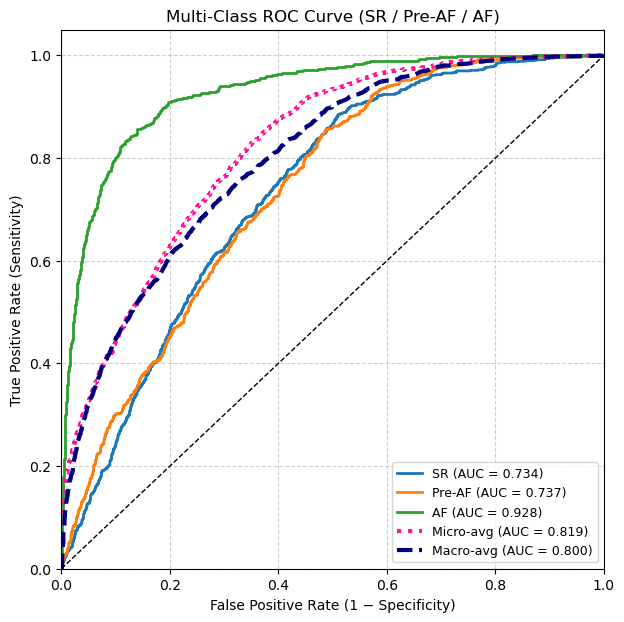

AUC[SR] = 0.7336
AUC[Pre-AF] = 0.7368
AUC[AF] = 0.9276
Micro-avg AUC = 0.8193
Macro-avg AUC = 0.7996


In [12]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F

num_classes = 3
y_all = [label for _, label in test_dataset]
y_true = np.array(y_all)  # labels: 0=SR, 1=Pre-AF, 2=AF

# --- Compute full probability matrix [N, 3] ---
probs_all = []

model.eval()
with torch.no_grad():
    for xb, _ in test_loader:
        xb = xb.to(device)
        out = model(xb)
        probs = F.softmax(out, dim=1).cpu().numpy()
        probs_all.append(probs)

probs_all = np.vstack(probs_all)   # shape [n_samples, 3]

# --- One-hot encode true labels ---
y_bin = label_binarize(y_true, classes=[0, 1, 2])

# --- Compute ROC curve & AUC for each class ---
fpr, tpr, roc_auc = {}, {}, {}
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], probs_all[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# --- Compute micro- and macro-average ROC ---
fpr["micro"], tpr["micro"], _ = roc_curve(y_bin.ravel(), probs_all.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Aggregate all FPRs
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))
# Then interpolate all ROC curves at these points
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= num_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# --- Plot ---
plt.figure(figsize=(7,7))
colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]
class_names = ["SR", "Pre-AF", "AF"]

for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f"{class_names[i]} (AUC = {roc_auc[i]:.3f})")

plt.plot(fpr["micro"], tpr["micro"], color="deeppink", linestyle=":", linewidth=3,
         label=f"Micro-avg (AUC = {roc_auc['micro']:.3f})")
plt.plot(fpr["macro"], tpr["macro"], color="navy", linestyle="--", linewidth=3,
         label=f"Macro-avg (AUC = {roc_auc['macro']:.3f})")

plt.plot([0,1],[0,1],'k--',lw=1)
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel("False Positive Rate (1 − Specificity)")
plt.ylabel("True Positive Rate (Sensitivity)")
plt.title("Multi-Class ROC Curve (SR / Pre-AF / AF)")
plt.legend(loc="lower right", fontsize=9)
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

# --- Print numeric results ---
for i, name in enumerate(class_names):
    print(f"AUC[{name}] = {roc_auc[i]:.4f}")
print(f"Micro-avg AUC = {roc_auc['micro']:.4f}")
print(f"Macro-avg AUC = {roc_auc['macro']:.4f}")


### Find threshold using validation data

In [26]:
# --- Create validation loader ---
val_dataset = TensorDataset(
    torch.from_numpy(X_val.astype(np.float32)),
    torch.from_numpy(y_val.astype(np.int64))
)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# --- Compute danger probabilities (VAL SET) ---
prob_danger_val, true_danger_val = [], []

model.eval()
with torch.no_grad():
    for xb, yb in val_loader:
        xb = xb.to(device)
        out = model(xb)
        probs = F.softmax(out, dim=1)  # shape [batch, 3]

        # P(SR) = probs[:,0], so danger = 1 - SR
        p_sr = probs[:, 0]
        p_danger = 1 - p_sr

        prob_danger_val.extend(p_danger.cpu().numpy())

        # Convert labels → binary danger: SR=0, (Pre-AF + AF)=1
        true_danger_val.extend((yb.numpy() != 0).astype(int))

prob_danger_val = np.array(prob_danger_val)
true_danger_val = np.array(true_danger_val)

print("🔍 Validation danger probability range:",
      prob_danger_val.min(), "-", prob_danger_val.max())
print("Validation danger label distribution:",
      np.bincount(true_danger_val))

# --- Sweep thresholds (VAL SET) ---
candidates = np.arange(0.0, 1.01, 0.01)
f1s, accs, precs, recs = [], [], [], []

for t in candidates:
    preds = (prob_danger_val >= t).astype(int)

    f1s.append(f1_score(true_danger_val, preds))
    accs.append(accuracy_score(true_danger_val, preds))
    precs.append(precision_score(true_danger_val, preds, zero_division=0))
    recs.append(recall_score(true_danger_val, preds))

max_f = max(f1s)
cut = 0.96 * max_f 

valid_idxs = [i for i, f in enumerate(f1s) if f >= cut]

# choose the largest threshold among valid candidates
best_idx = max(valid_idxs)
best_t = candidates[best_idx]

print(f"\n🎯 BEST THRESHOLD (96% F1 rule) = {best_t:.3f}")
print(f"Max F1 = {max_f:.4f}")
print(f"Chosen threshold F1 = {f1s[best_idx]:.4f}, Acc = {accs[best_idx]:.4f}, "
      f"Prec = {precs[best_idx]:.4f}, Rec = {recs[best_idx]:.4f}")

# Final threshold used in inference
window_threshold = best_t


🔍 Validation danger probability range: 0.262677 - 0.9888448
Validation danger label distribution: [ 768 1529]

🎯 BEST THRESHOLD (96% F1 rule) = 0.560
Max F1 = 0.7994
Chosen threshold F1 = 0.7717, Acc = 0.6905, Prec = 0.7579, Rec = 0.7861


In [27]:
# --- Show all thresholds with F1 and Accuracy ---
print("\n========== Threshold Summary ==========")
print(f"{'Threshold':<10} {'F1':<10} {'Accuracy':<10}")
print("-" * 35)

for i, t in enumerate(candidates):
    print(f"{t:<10.2f} {f1s[i]:<10.4f} {accs[i]:<10.4f}")




========== Threshold Summary ==========
Threshold  F1         Accuracy  
-----------------------------------
0.00       0.7993     0.6657    
0.01       0.7993     0.6657    
0.02       0.7993     0.6657    
0.03       0.7993     0.6657    
0.04       0.7993     0.6657    
0.05       0.7993     0.6657    
0.06       0.7993     0.6657    
0.07       0.7993     0.6657    
0.08       0.7993     0.6657    
0.09       0.7993     0.6657    
0.10       0.7993     0.6657    
0.11       0.7993     0.6657    
0.12       0.7993     0.6657    
0.13       0.7993     0.6657    
0.14       0.7993     0.6657    
0.15       0.7993     0.6657    
0.16       0.7993     0.6657    
0.17       0.7993     0.6657    
0.18       0.7993     0.6657    
0.19       0.7993     0.6657    
0.20       0.7993     0.6657    
0.21       0.7993     0.6657    
0.22       0.7993     0.6657    
0.23       0.7993     0.6657    
0.24       0.7993     0.6657    
0.25       0.7993     0.6657    
0.26       0.7993     0.6657    

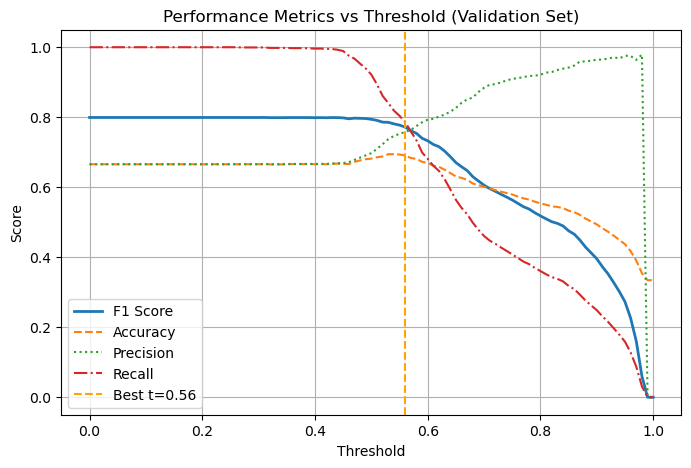

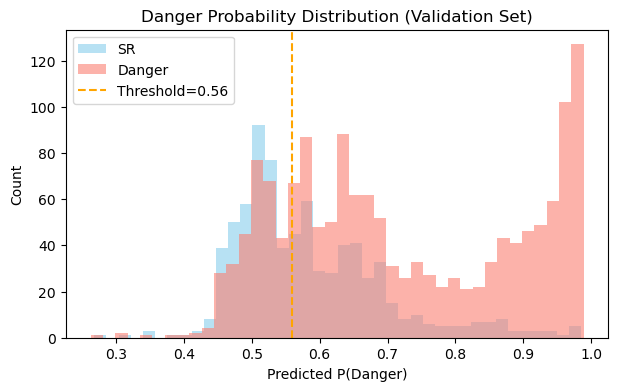

In [28]:

plt.figure(figsize=(8,5))
plt.plot(candidates, f1s, label="F1 Score", linewidth=2)
plt.plot(candidates, accs, label="Accuracy", linestyle="--")
plt.plot(candidates, precs, label="Precision", linestyle=":")
plt.plot(candidates, recs, label="Recall", linestyle="-.")
plt.axvline(best_t, color="orange", linestyle="--", label=f"Best t={best_t:.2f}")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Performance Metrics vs Threshold (Validation Set)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(7,4))
plt.hist(prob_danger_val[true_danger_val==0], bins=40, alpha=0.6, label="SR", color="skyblue")
plt.hist(prob_danger_val[true_danger_val==1], bins=40, alpha=0.6, label="Danger", color="salmon")
plt.axvline(best_t, color="orange", linestyle="--", label=f"Threshold={best_t:.2f}")
plt.xlabel("Predicted P(Danger)")
plt.ylabel("Count")
plt.title("Danger Probability Distribution (Validation Set)")
plt.legend()
plt.show()

### Find Predicted Time Horizon

In [29]:
print("\n================ TIME HORIZON (TEST SET) ================")
print("Using threshold:", window_threshold)

# --- Reload dataset ---
DATA_PATH = os.path.join("..", "Dataset", "raw_RRI_segments.csv")
window_duration_sec = 30

df = pd.read_csv(DATA_PATH)
feature_cols = [c for c in df.columns if c.startswith("r_")]

# Clean dataset like before
X = df[feature_cols].values.astype(np.float32)
y_raw = df["label"].values
mask_good = np.isfinite(X).all(axis=1)
mask_good &= np.isfinite(y_raw) & (y_raw >= 0)
df_clean = df.loc[mask_good].reset_index(drop=True)

aligned_record_ids = df_clean["record_id"].values
y_all = df_clean["label"].values.astype(int)

print("Cleaned dataset:", df_clean.shape)

# --- Compute danger for TEST SET windows ---
prob_danger_test = []

test_loader = DataLoader(
    TensorDataset(torch.from_numpy(X_test.astype(np.float32)),
                  torch.from_numpy(y_test.astype(np.int64))),
    batch_size=32, shuffle=False
)

model.eval()
with torch.no_grad():
    for xb, _ in test_loader:
        xb = xb.to(device)
        out = model(xb)
        probs = F.softmax(out, dim=1)
        prob_danger_test.extend((1 - probs[:, 0]).cpu().numpy())

prob_danger_test = np.array(prob_danger_test)

# --- Align lengths (if mismatch) ---
min_len = min(len(prob_danger_test), len(aligned_record_ids))
prob_danger_test = prob_danger_test[:min_len]
aligned_record_ids = aligned_record_ids[:min_len]
y_all = y_all[:min_len]

# --- Find AF onset per record ---
record_af_onset_indices = {}
unique_records = np.unique(aligned_record_ids)

for rid in unique_records:
    idxs = np.where(aligned_record_ids == rid)[0]
    labels = y_all[idxs]
    af_idx = np.where(labels == 2)[0]
    if len(af_idx) > 0:
        record_af_onset_indices[rid] = af_idx[0]

print("Found AF onset in", len(record_af_onset_indices), "records")

# --- Compute time horizon ---
time_horizons = []

for rid, onset_idx in record_af_onset_indices.items():
    idxs = np.where(aligned_record_ids == rid)[0]
    probs = prob_danger_test[idxs]

    first_alert = np.where(probs >= window_threshold)[0]

    if len(first_alert) > 0 and first_alert[0] < onset_idx:
        delta = onset_idx - first_alert[0]
        time_horizons.append(delta * window_duration_sec)

# --- SUMMARY ---
if time_horizons:
    print(f"\nMean predicted time horizon: {np.mean(time_horizons):.2f} s")
    print(f"Median predicted time horizon: {np.median(time_horizons):.2f} s")
    print(f"Detected {len(time_horizons)} AF records early.")
else:
    print("\n⚠️ No early detections found.")


================ TIME HORIZON (TEST SET) ================
Using threshold: 0.56
Cleaned dataset: (14357, 55)
Found AF onset in 19 records

Mean predicted time horizon: 2981.05 s
Median predicted time horizon: 3000.00 s
Detected 19 AF records early.
